# Homework 7
**Total Points: 5**

**Instructions:**
1. Complete parts 1 through 5, filling in code or responses where marked with `# YOUR CODE HERE` or `# YOUR ANALYSIS HERE`.
2. The libraries you need have already been coded. Do not import additional libraries or move import commands.
3. When finished, run the full notebook by selecting <b>Kernel > Restart & Run All</b>. </li>
4. Submit this completed notebook file to <b>NYU Classes</b>. </li>**(Important: Only submit your .ipynb file! Do not submit the entire dataset.)**

In this assignment you will test two different techniques to estimate beat positions: spectral flux and a recurrent neural network. This assignment uses *GuitarSet*, a dataset of solo guitar recordings, and accompanying ground truth beat annotations. The beats are included with this assignment and the GuitarSet audio files can be downloaded separately.

<blockquote>
Q. Xi, R. Bittner, J. Pauwels, X. Ye, and J. P. Bello, "Guitarset: A Dataset for Guitar Transcription", in 19th International Society for Music Information Retrieval Conference, Paris, France, Sept. 2018.
</blockquote>

This assignment uses two new libraries, `madmom`, which contains additional signal processing tools, and `mir_eval` to calculate f_measure for beat tracking. You can install both from the command line using `pip`. More information about madmom is available here: https://madmom.readthedocs.io/ 

**Grading:** Each part is worth 1 point.

## Prologue: Download GuitarSet and Beat Position Data

The data you will need is a folder containing .wav audio files, and a separate folder containing .txt files with times indicating the ground truth beats. The text files are in `GuitarSet_beats.zip` as part of this assignment The GuitarSet audio files are available here:

https://zenodo.org/record/3371780

**You don't need the entire dataset.** Only download the file `audio_mono-mic.zip`, which is about 670MB. 

Download and extract both the dataset and the beat position data. Place the data into folders in the same directory as your `Homework-7.ipynb` file, such that the folder stucture is:

`
 .
 <--   Homework-7.ipynb
 <--   GuitarSet_beats
 |     <--   *.txt files      
 <--   audio_mono-mic   
 |     <--   *.wav files
`

The `*.wav` audio files contain guitar recordings from 6 different players and a variety of speeds and styles. Each audio file has a matching filename `*.txt`, which contains ground truth times for each beat. 

To get all the filenames in a specific directory, use the `os` library as follows:

`
for filename in os.listdir("GuitarSet_beats/"):
    if filename.endswith(".txt"):
        ...
`

To import a text file as a numpy array, use numpy's `loadtxt`.

In [187]:
import librosa
from librosa import display
import IPython.display as ipd
import os
import numpy as np
import madmom
import matplotlib.pyplot as plt
from mir_eval.beat import f_measure

## Part 1: Estimate Beats

Write a function `estimate_beats()` that estimates beat positions using one of two methods:

- a spectral flux onset novelty curve
- a recurrent neural network

Using the novelty curve from one of the above methods, generate a tempogram and calculate the predominant local pulse. You may use Librosa's `plp` and `onset_strength` functions, and madmom's `RNNBeatProcessor`. Do not use Librosa's `beat_track`.

In a recurrent neural network (RNN), the output is "remembered" and used when calculating subsequent outputs; it is useful for series data such as with speech recognition. For example, predicting the next day of the week is determined by the current day (if the previous output is "Wednesday", the next output should be "Thursday").  In our case, the RNN will be used to generate a novelty curve, where the ouput is the probability of a beat at a particular frame. More information is available in madmom's documentation: https://madmom.readthedocs.io/en/latest/modules/features/beats.html.

In [2]:
def estimate_beats(audio_path, onset_type, plot=False):
    """Compute beat positions using either a spectral flux or a machine learned onset novelty function,
    followed by computing a tempogram and PLP.
    
    Parameters
    ----------
    audio_path : str
        Path to input audio file
    onset_type : str
        One of 'spectral_flux' or 'machine_learning'
    plot : bool
        If True, plots the onset novelty curve and the estimated beat positions.
    Returns
    -------
    beat_times : 1-d np.array
        Array of time stamps of the estimated beats in seconds.

    """
    x, sr = librosa.load(audio_path)
    if (onset_type == "spectral_flux"): # estimate beat positions using a spectral flux onset novelty curve
        y = librosa.onset.onset_strength(x)
    elif (onset_type == "machine_learning"): # estimate using a RNN
        proc = madmom.features.beats.RNNBeatProcessor()
        y = proc(x)
    else:
        print("Please use either 'spectral_flux' or 'machine_learning.'")

    z = librosa.beat.plp(y=None, onset_envelope=y, tempo_min=30,tempo_max=200)
    beats = np.flatnonzero(librosa.util.localmax(z))
    plp_len = z.shape[0]
    beats = beats * (len(x)/sr) / plp_len
    clicks = librosa.clicks(beats,sr=sr) # click track
    return clicks, beats

#for i in directory:
#    x, sr = librosa.load("audio_mono-mic/" + directory[i])
#    directory = os.listdir("audio_mono-mic/")
#    clicks, beats = estimate_beats("audio_mono-mic/" + directory[i], 'machine_learning', plot=False) # calls function
#    ipd.Audio(clicks[0:646206] + x[0:646206], rate = 22050)

## Part 2: Evaluate Beats

Evaluate the beat estimates for each track in GuitarSet using mir_eval's `f_measure(reference_beats, estimated_beats, f_measure_threshold=0.07)`. Do this by creating two dictionaries, one for SF beats and one for the ML beats. The keys of the dictionaries should be the GuitarSet file name without the extension (`00_BN1-129-Eb_solo`), and the value for each key should be the f-measure, which should evaluate the predicted beats vs. the ground truth beats for each method.

In [3]:
scores_sf = {} # dictionary where key is file name w/o extension, value is f-measure when using spectral flux
scores_ml = {} # dictionary where key is file name w/o extension, value is f-measure when using RNN

directory = os.listdir("audio_mono-mic/")
for i in directory:
    r = i.split('.')[0] + ".txt"
    reference_beats = np.loadtxt("GuitarSet_beats/"+ r)
    clicks, ml_estimate = estimate_beats("audio_mono-mic/" + i, 'machine_learning', plot=False)
    key = i.split('.')[0]
    scores_ml[key] = f_measure(reference_beats, ml_estimate, f_measure_threshold=0.07)
for i in directory:
    r = i.split('.')[0] + ".txt"
    reference_beats = np.loadtxt("GuitarSet_beats/"+ r)
    clicks, sf_estimate = estimate_beats("audio_mono-mic/" + i, 'spectral_flux', plot=False)
    key = i.split('.')[0]
    scores_sf[key] = f_measure(reference_beats, sf_estimate, f_measure_threshold=0.07)


In [4]:
# Run this code to test your dictionaries

example_trackid = "00_BN1-129-Eb_comp_mic"
print("The spectral flux beats f-measure for {} is {}".format(example_trackid, scores_sf[example_trackid]))
print("The machine learned beats f-measure for {} is {}".format(example_trackid, scores_ml[example_trackid]))
print("")
print("The average f-measure for spectral flux beats is {}".format(np.mean(list(scores_sf.values()))))
print("The average f-measure for machine learned beats is {}".format(np.mean(list(scores_ml.values()))))


The spectral flux beats f-measure for 00_BN1-129-Eb_comp_mic is 0.28301886792452835
The machine learned beats f-measure for 00_BN1-129-Eb_comp_mic is 0.15730337078651688

The average f-measure for spectral flux beats is 0.4282715731094961
The average f-measure for machine learned beats is 0.5206680686508164


## Part 3: Plot Results

Plot overall results and results of specific groups (player, style, tempo, and mode) by splitting the data. This is useful to identify trends in addition to the overall results. The audio and data filenames contain information needed to split the tracks (you may find `split()` to be useful) and can be parsed as follows:

`<player id>_<style>-<tempo>-<key>_<solo or comp>_mic.txt/wav`

Plot the scores as boxplots using [matplotlib.pyplot.boxplot](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html). The boxplots will show the median, quantiles, and range of the scores across tracks. All of your plots should have axis labels, titles and legends.

Create each of the following plots:

1. **Overall scores**: A single figure with two boxplots. One using the scores for all tracks for SF beats and one for ML beats.
2. **Scores by player**: A figure with two subplots (one row, two columns). The left subplot should have scores for SF beats and the right for ML beats. Each subplot should contain 6 boxplots, where each boxplot is computed for the tracks played by one player.
3. **Scores by playing mode**: A figure with two subplots (one row, two columns). The left subplot should have scores for SF beats and the right for ML beats. Each subplot should contain 2 boxplots, where each boxplot is computed for the playing mode ('solo' or 'comp').
4. **Scores by genre/style**: A figure with two subplots (one row, two columns). The left subplot should have scores for SF beats and the right for ML beats. Each subplot should contain 5 boxplots, where each boxplot is computed for the style (Bossa Nova, Funk, ...).
5. **Scores by tempo**: A figure with two subplots (one row, two columns). The left subplot should have scores for SF beats and the right for ML beats. Each subplot should contain one **scatter plot** (not a boxplot), which has tempo in BPM as the x-axis and f-measure as the y-axis.

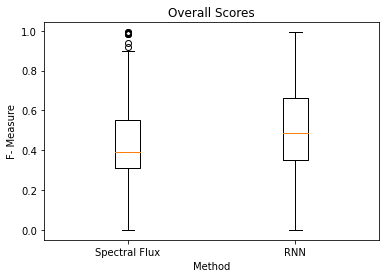

In [16]:
# Overall scores
sf = list(scores_sf.values())
ml = list(scores_ml.values())

data = [sf,ml]
bp, ax = plt.subplots()

box_dict = ax.boxplot(data)

ax.set_xticklabels(['Spectral Flux', 'RNN'])
plt.title ('Overall Scores')
plt.xlabel('Method')
plt.ylabel('F- Measure')
plt.show(bp)


In [71]:
def split_by_player(scores_dictionary):
    """Split scores by player id

    Parameters
    ----------
    scores_dictionary : dict
        Dictionary of scores keyed by track_id

    Returns
    -------
    player_scores : dict
        Dictionary with player ids as keys and a
        dictionary of scores keyed by track_id as values

    """
    player_scores = {}
    player_list = []

    for key, value in scores_dictionary.items():
        player = key.split('_')[0]
        player_list.append(player) 
        
    player_list = list(set(player_list))
    player_list.sort() # sorted
    
    for s in player_list:
        player_scores[s] = {} # empties out all values
    
    for key, value in scores_dictionary.items():
        for s in player_list:
            if key.split('_')[0] == s:
                player_scores[s].update({key:value})

    return player_scores


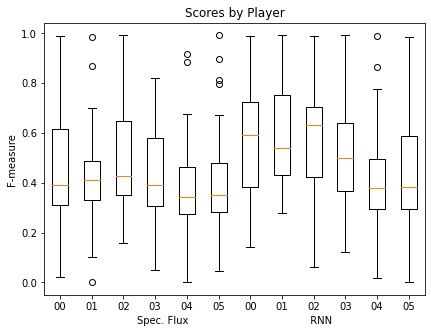

In [78]:
player_scores_sf = split_by_player(scores_sf)
player_scores_ml = split_by_player(scores_ml)

# Scores by player figure
labels_sf, data_sf = [*zip(*player_scores_sf.items())]
labels_ml, data_ml = [*zip(*player_scores_ml.items())]

data = []
for i in range(len(labels_sf)):
    labels_temp, data_temp = [*zip(*data_sf[i].items())]
    data.append(data_temp)
    
for i in range(len(labels_ml)):
    labels_temp, data_temp = [*zip(*data_ml[i].items())]
    data.append(data_temp)

fig = plt.figure(figsize = (15,5))
ax1 = plt.subplot(1,2,1)
bp = ax1.boxplot(data)

box_dict = ax.boxplot(data)

ax1.set_xticklabels(['00', '01', '02', '03', '04', '05','00', '01', '02', '03', '04', '05'])
plt.title ('Scores by Player')
plt.xlabel('Spec. Flux                                       RNN')
plt.ylabel('F-measure')
plt.show(bp)

In [62]:
def split_by_mode(scores_dictionary):
    """Split scores by mode ('solo' or 'comp')

    Parameters
    ----------
    scores_dictionary : dict
        Dictionary of scores keyed by track_id

    Returns
    -------
    mode_scores : dict
        Dictionary with mode as keys and a
        dictionary of scores keyed by track_id as values

    """
    mode_scores = {}
    mode_list = []

    for key, value in scores_dictionary.items():
        mode = key.split('_')[2]
        mode_list.append(mode) # now have list of 5 styles or whatever
        
    mode_list = list(set(mode_list))
    mode_list.sort() # sorted
    
    for s in mode_list:
        mode_scores[s] = {} # empties out all values
    
    for key, value in scores_dictionary.items():
        for s in mode_list:
            if key.split('_')[2] == s:
                mode_scores[s].update({key:value})

    return mode_scores
    

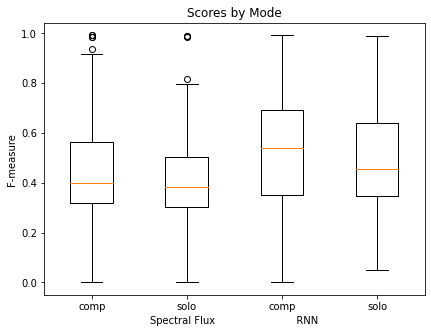

In [65]:
mode_scores_sf = split_by_mode(scores_sf)
mode_scores_ml = split_by_mode(scores_ml)

# Scores by playing mode figure
labels_sf, data_sf = [*zip(*mode_scores_sf.items())]
labels_ml, data_ml = [*zip(*mode_scores_ml.items())]

data = []
for i in range(len(labels_sf)):
    labels_temp, data_temp = [*zip(*data_sf[i].items())]
    data.append(data_temp)
    
for i in range(len(labels_ml)):
    labels_temp, data_temp = [*zip(*data_ml[i].items())]
    data.append(data_temp)

fig = plt.figure(figsize = (15,5))
ax1 = plt.subplot(1,2,1)
bp = ax1.boxplot(data)

box_dict = ax.boxplot(data)

ax1.set_xticklabels(['comp', 'solo', 'comp', 'solo'])
plt.title ('Scores by Mode')
plt.xlabel('Spec. Flux                          RNN')
plt.ylabel('F-measure')
plt.show(bp)

In [29]:
def split_by_style(scores_dictionary):
    """Split scores by style

    Parameters
    ----------
    scores_dictionary : dict
        Dictionary of scores keyed by track_id
        track_id --- f scores

    Returns
    -------
    style_scores : dict
        Dictionary with style as keys and a
        dictionary of scores keyed by track_id as values
        style --- [track id--- f scores]
    """
    style_scores = {}
    style_list = []
    # YOUR CODE HERE
    
    # EXAMPLE
    # style_scores[style][track_id] = scores_dictionary[track_id]
    for key, value in scores_dictionary.items():
        style = key.split('_')[1]
        style = style.split('-')[0]
        style = style[:-1]
        style_list.append(style) # now have list of 5 styles or whatever
        
    style_list = list(set(style_list))
    style_list.sort() # sorted
    
    for s in style_list:
        style_scores[s] = {} # empties out all values
    
    for key, value in scores_dictionary.items():
        style = key.split('_')[1]
        style = style.split('-')[0]
        style = style[:-1]
        for s in style_list:
            if style == s:
                style_scores[s].update({key:value})
    
    return style_scores

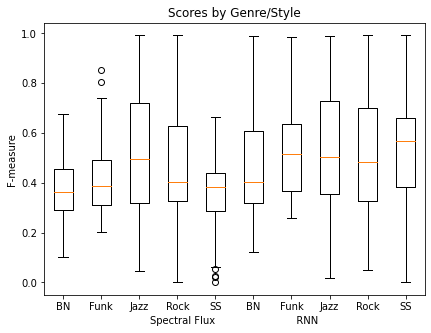

In [46]:
style_scores_sf = split_by_style(scores_sf)
style_scores_ml = split_by_style(scores_ml)

labels_sf, data_sf = [*zip(*style_scores_sf.items())]
labels_ml, data_ml = [*zip(*style_scores_ml.items())]

data = []
for i in range(len(labels_sf)):
    labels_temp, data_temp = [*zip(*data_sf[i].items())]
    data.append(data_temp)
    
for i in range(len(labels_ml)):
    labels_temp, data_temp = [*zip(*data_ml[i].items())]
    data.append(data_temp)

fig = plt.figure(figsize = (15,5))
ax1 = plt.subplot(1,2,1)
bp = ax1.boxplot(data)

box_dict = ax.boxplot(data)

ax1.set_xticklabels(['BN', 'Funk', 'Jazz', 'Rock', 'SS', 'BN', 'Funk', 'Jazz', 'Rock', 'SS'])
plt.title ('Scores by Genre/Style')
plt.xlabel('Spec. Flux                          RNN')
plt.ylabel('F-measure')
plt.show(bp)


In [112]:
def get_tempo_vs_score(scores_dictionary):
    """Get score values as a function of tempo

    Parameters
    ----------
    scores_dictionary : dict
        Dictionary of scores keyed by track_id

    Returns
    -------
    tempo : np.array
        Array of tempo values with the same number of elements as scores_dictionary
    scores : np.array
        Array of scores with the same number of elements as scores_dictionary
    """
    
    """"
    tempos = []
    scores = []

    for key, value in scores_dictionary.items():
        tempo = key.split('-')[1]
        tempos.append(tempo) 
        
    tempos.sort() # sorted

    for key, value in scores_dictionary.items():
        for s in tempos:
            if key.split('-')[1] == s:
                scores.append(value)
    print(len(tempos))
    print(len(scores)) # SCORES IS WRONG SIZE MUCH TOO LARGE
    return tempos, scores
    """
    tempos = []
    scores = []
    
    tempo_scores = {}
    tempo_list = []

    for key, value in scores_dictionary.items():
        tempo = key.split('-')[1]
        tempo_list.append(tempo) 
        
    tempo_list = list(set(tempo_list))
    tempo_list.sort() # sorted
    
    for s in tempo_list:
        tempo_scores[s] = {} # empties out all values
    
    for key, value in scores_dictionary.items():
        for s in tempo_list:
            if key.split('-')[1] == s:
                tempo_scores[s].update({key:value})
                
    tempos = tempo_list
    scores = tempo_scores.values() 

    return tempos, scores


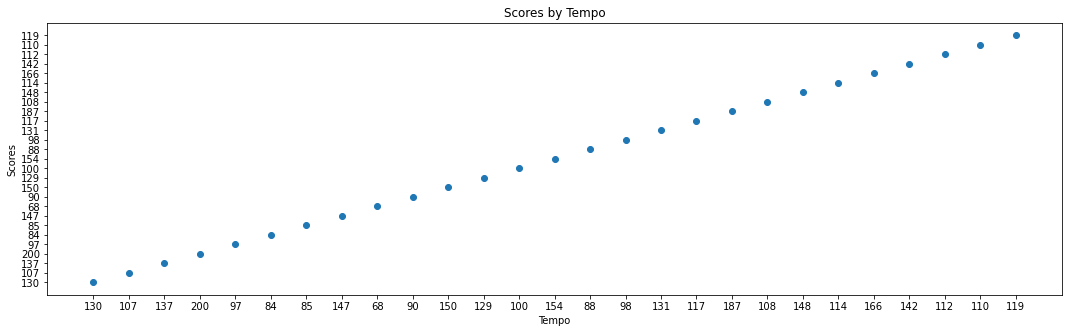

In [147]:
tempo_sf, score_by_tempo_sf = get_tempo_vs_score(scores_sf)
tempo_ml, score_by_tempo_ml = get_tempo_vs_score(scores_ml)
"""
# Scores by tempo figure
labels_sf = tempo_sf
labels_ml = tempo_ml

data = [score_by_tempo_sf, score_by_tempo_ml]
        
fig = plt.figure(figsize = (15,5))
ax1 = plt.subplot(1,2,1)
bp = ax1.scatter(labels_sf, score_by_tempo_sf) # x and y OF SCATTER MUST BE SAME SIZE

box_dict = ax.boxplot(data)
print(labels_sf)
print(labels_ml)
ax1.set_xticklabels(['jkl'])
plt.title ('Scores by Tempo')
plt.xlabel('BPM')
plt.ylabel('F-measure')
plt.show(bp)
"""

# Scores by player figure
labels_sf, data_sf = [*zip(*score_by_tempo_sf.items())]
labels_ml, data_ml = [*zip(*score_by_tempo_ml.items())]

data = []
for i in range(len(labels_sf)):
    labels_temp, data_temp = [*zip(*data_sf[i].items())]
    data.append(data_temp)
    
for i in range(len(labels_ml)):
    labels_temp, data_temp = [*zip(*data_ml[i].items())]
    data.append(data_temp)
    
labels_sf = list(set(labels_sf))
#res = [value for values in data_sf for value in values] 
#print("The dictionary tuple key elements are : " + str(res)) 

fig = plt.figure(figsize = (40,5))
ax1 = plt.subplot(1,2,1)

plt.scatter(labels_sf, labels_sf) # Incomplete, hoping for partial credit
#ax1.set_xticklabels(['100', '107', '108', '110', '112', '114', '117', '119', '129', '130', '131', '137', '142', '147', '148', '150', '154', '166', '187', '200', '68', '84', '85', '88', '90', '97', '98','100', '107', '108', '110', '112', '114', '117', '119', '129', '130', '131', '137', '142', '147', '148', '150', '154', '166', '187', '200', '68', '84', '85', '88', '90', '97', '98'])
plt.title ('Scores by Tempo')
plt.xlabel('Tempo')
plt.ylabel('Scores')
plt.show(bp)

## Part 4: Plot & Sonify Individual Results

Write a function `plot_and_sonify_outputs()` that computes, plots and sonifies the outputs of `estimate_beats()`. The function should do the following:

1. Plot the spectral flux novelty curve and the estimated beats as vertical lines.
2. Plot the machine learned novelty curve and the estimated beats as vertical lines.
3. Plot the audio and the reference beats as vertical lines.
    
Also generate a click track at the beat positions (using `librosa.clicks`) and add the resulting audio file to the original audio for each of:

1. the SF beats
2. the ML beats
3. the reference beats
    
In total, for one track_id, this function should create 3 plots and 3 playable audio widgets. To allow more than one audio widget to appear:


`audio1 = IPython.display.Audio(...)
audio2 = IPython.display.Audio(...)
IPython.display.display(audio1)
IPython.display.display(audio2)
`

In [293]:
def plot_and_sonify_outputs(track_id):
    """For a given track ID, compute, plot and sonify results.
    
    Parameters
    ----------
    track_id : str
        GuitarSet track_id

    Returns
    -------
    None

    """
    # For SPECTRAL FLUX
    x, fs = librosa.load("audio_mono-mic/" + track_id +".wav")
    directory = os.listdir("audio_mono-mic/")
    clicks, beats = estimate_beats("audio_mono-mic/" + track_id + ".wav", 'spectral_flux', plot=False) # calls function
    # Audio Player
    length = 0
    if (len(x) > len(clicks)):
        length = len(clicks)
    else:
        length = len(x)
    audio1 = ipd.Audio(clicks[0:length] + x[0:length], rate = 22050)
    
    # FOR MACHINE LEARNING
    x2, fs = librosa.load("audio_mono-mic/" + track_id +".wav")
    directory = os.listdir("audio_mono-mic/")
    clicks2, beats2 = estimate_beats("audio_mono-mic/" + track_id + ".wav" , 'machine_learning', plot=False) # calls function
    # Audio Player
    length2 = 0
    if (len(x2) > len(clicks2)):
        length2 = len(clicks2)
    else:
        length2 = len(x2)
    audio2 = ipd.Audio(clicks2[0:length2] + x2[0:length2], rate = 22050)
    
    # FOR REFERENCE----
    x3, fs = librosa.load("audio_mono-mic/" + track_id +".wav")
    directory = os.listdir("audio_mono-mic/")
    reference_beats = np.loadtxt("GuitarSet_beats/"+ track_id +".txt")
    clicks3 = librosa.clicks(reference_beats,sr=fs) # click track added here

    # Audio Player
    length3 = 0
    if (len(x3) > len(clicks3)):
        length3 = len(clicks3)
    else:
        length3 = len(x3) 
    audio3 = ipd.Audio(clicks3[0:length3] + x3[0:length3], rate = 22050)
    
    # Display all audio players
    ipd.display(audio1)
    ipd.display(audio2)
    ipd.display(audio3)
    
    win_length = 2048
    hop_length = int(win_length/2)
    
    # Plot 1 - Spectral Flux
    frames = range(len(x))
    t = librosa.frames_to_time(frames, hop_length)
    y = librosa.onset.onset_strength(x)
    plt.figure(figsize=(15, 17))
    ax = plt.subplot(3, 1, 1)
    ax.vlines(beats, x.min(), x.max(), color='r', alpha=0.7)
    ax.margins(x=0)
    #plt.plot(y)
    #plt.xticks([200, 400, 600, 800, 1000, 1200], np.linspace(0,30,6))
    plt.title("Audio File and Spectral Flux Beats")
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude')

    
    # Plot 2 = ML
    frames2 = range(len(x2))
    t2 = librosa.frames_to_time(frames2, hop_length)
    plt.figure(figsize=(15, 17))
    ax2 = plt.subplot(3, 1, 2)
    ax2.vlines(beats2, x2.min(), x2.max(), color='r', alpha=0.7)
    ax2.margins(x=0)
    #librosa.display.waveplot(x2, fs, ax=ax2)
    plt.title("Audio File and RNN Beats")
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude')
    
    # Plot 2 = Reference
    frames3 = range(len(x3))
    t3 = librosa.frames_to_time(frames3, hop_length)
    plt.figure(figsize=(15, 17))
    ax3 = plt.subplot(3, 1, 2)
    ax3.vlines(reference_beats, x3.min(), x3.max(), color='r', alpha=0.7)
    ax3.margins(x=0)
    librosa.display.waveplot(x3, fs)
    plt.title("Audio File and Reference Beats")
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude')
    

In [294]:
# run this and the cells below 
best_track_sf = max(scores_sf, key=scores_sf.get)  # the track with the best score for SF Beats
best_track_ml = max(scores_ml, key=scores_ml.get)  # the track with the best score for ML Beats
worst_track_sf = min(scores_sf, key=scores_sf.get)  # the track with the worst score for SF Beats
worst_track_ml = min(scores_ml, key=scores_ml.get)  # the track with the worst score for ML Beats

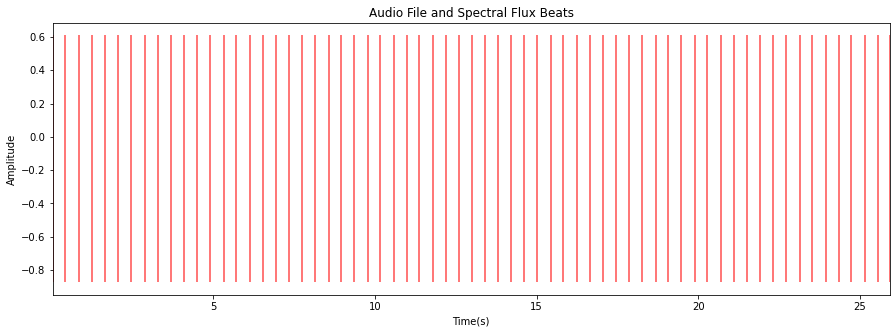

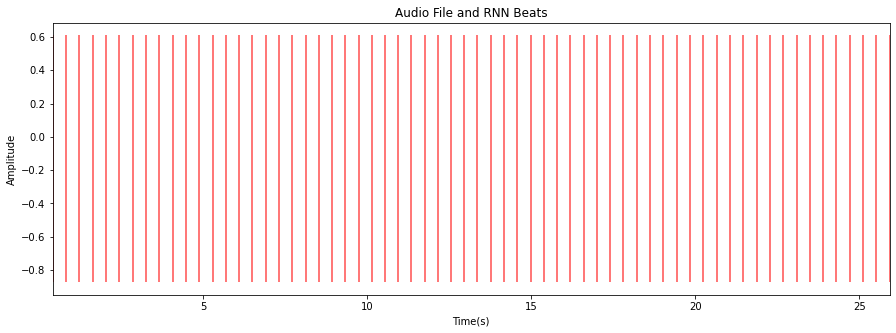

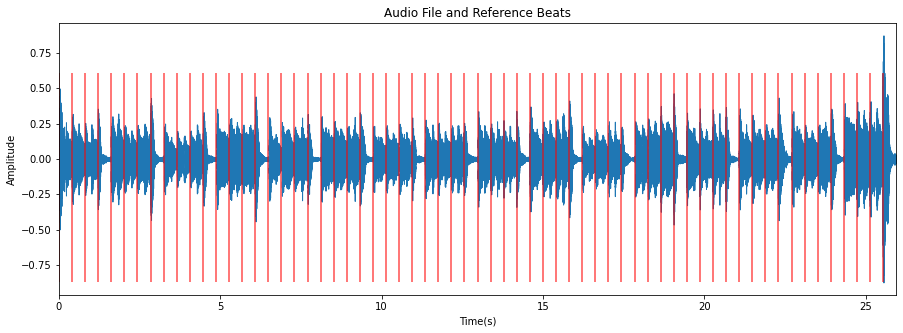

In [295]:
plot_and_sonify_outputs(best_track_sf)


In [ ]:
plot_and_sonify_outputs(best_track_ml)


In [179]:
plot_and_sonify_outputs(worst_track_sf)


In [180]:
plot_and_sonify_outputs(worst_track_ml)


## Part 5: Analysis

Using the plots from part 3 and part 4, identify 3 different trends (e.g. if one algorithm performs better than the other overall, if one algorithm performs better on different splits than others, etc). Create additional plots or audio if necessary in your analysis. For each trend discuss what is happening and why it might be occuring.

`# Trend: The ML RNN algorithm performs significantly better than the spectral flux algorithm on all splits. The RNN performed better overall, by player, by mode, and by genre. The RNN performs better because it uses model to predict if each time frame is a beat or not. It takes more information into account when making the predictions.

The BN genre had some of the lowest performance. I assume BN represents bossa nova. Perhaps it scores lower because of the unusual synchopated rhythm in the style of music. In terms of mode, 'comp' performs much bettern than 'solo' when analyzed with an RNN. Comp includes more context, the algorithm has more information with which to analyze beats.  

